In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [36]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [37]:
# Load the dataset
df = pd.read_csv('train.csv')
print(f"Dataset shape: {df.shape}")

Dataset shape: (15120, 56)


In [38]:
# Display basic information
print("\nDataset info:")
print(df.info())



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  

In [39]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"\nMissing values: {missing_values.sum()}")


Missing values: 0


In [40]:
# Define cover type names
cover_type_names = {
    1: 'Spruce/Fir',
    2: 'Lodgepole Pine', 
    3: 'Ponderosa Pine',
    4: 'Cottonwood/Willow',
    5: 'Aspen',
    6: 'Douglas-fir',
    7: 'Krummholz'
}

In [41]:
# Analyze target distribution
target_counts = df['Cover_Type'].value_counts().sort_index()
print("\nTarget variable distribution:")
for cover_type, count in target_counts.items():
    percentage = (count / len(df)) * 100
    print(f"Class {cover_type}: {cover_type_names[cover_type]} - {count} samples ({percentage:.1f}%)")


Target variable distribution:
Class 1: Spruce/Fir - 2160 samples (14.3%)
Class 2: Lodgepole Pine - 2160 samples (14.3%)
Class 3: Ponderosa Pine - 2160 samples (14.3%)
Class 4: Cottonwood/Willow - 2160 samples (14.3%)
Class 5: Aspen - 2160 samples (14.3%)
Class 6: Douglas-fir - 2160 samples (14.3%)
Class 7: Krummholz - 2160 samples (14.3%)


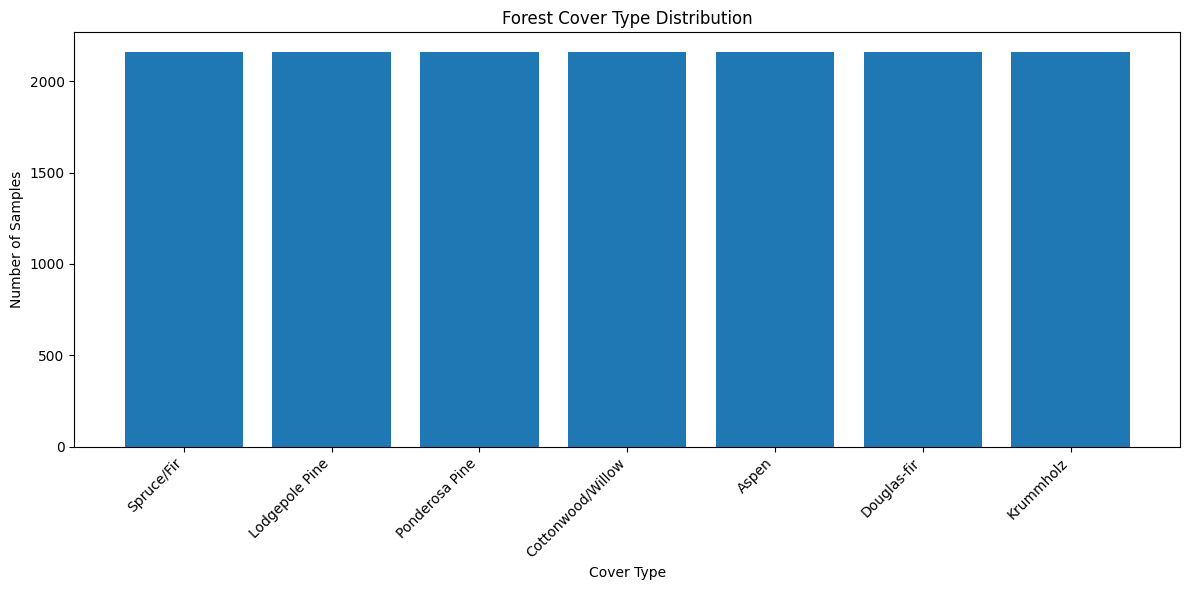

In [42]:
# Visualize target distribution
plt.figure(figsize=(12, 6))
bars = plt.bar([cover_type_names[i] for i in target_counts.index], target_counts.values)
plt.title('Forest Cover Type Distribution')
plt.xlabel('Cover Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
# Separate features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

In [44]:
# Identify feature types
numeric_features = [
    'Elevation', 'Aspect', 'Slope', 
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'
]

wilderness_cols = [col for col in X.columns if 'Wilderness_Area' in col]
soil_cols = [col for col in X.columns if 'Soil_Type' in col]

print(f"\nFeature breakdown:")
print(f"Numeric features: {len(numeric_features)}")
print(f"Wilderness areas: {len(wilderness_cols)}")
print(f"Soil types: {len(soil_cols)}")


Feature breakdown:
Numeric features: 10
Wilderness areas: 4
Soil types: 40


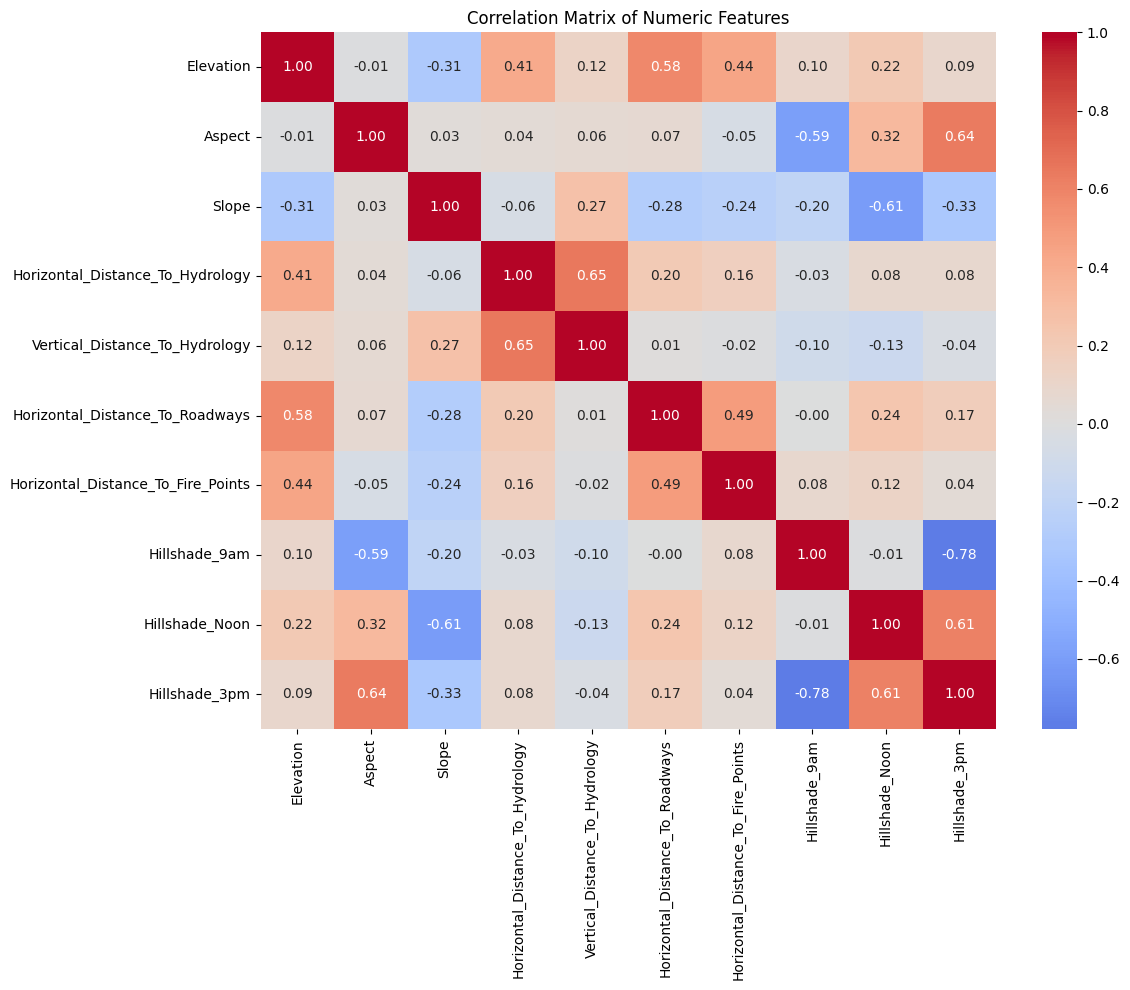

In [45]:
# Correlation analysis
plt.figure(figsize=(12, 10))
corr_matrix = X[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()


C:\Users\conta\AppData\Local\Temp\ipykernel_15688\2966682086.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels([cover_type_names[i] for i in range(1, 8)], rotation=45)
C:\Users\conta\AppData\Local\Temp\ipykernel_15688\2966682086.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels([cover_type_names[i] for i in range(1, 8)], rotation=45)
C:\Users\conta\AppData\Local\Temp\ipykernel_15688\2966682086.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels([cover_type_names[i] for i in range(1, 8)], rotation=45)
C:\Users\conta\AppData\Local\Temp\ipykernel_15688\2966682086.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

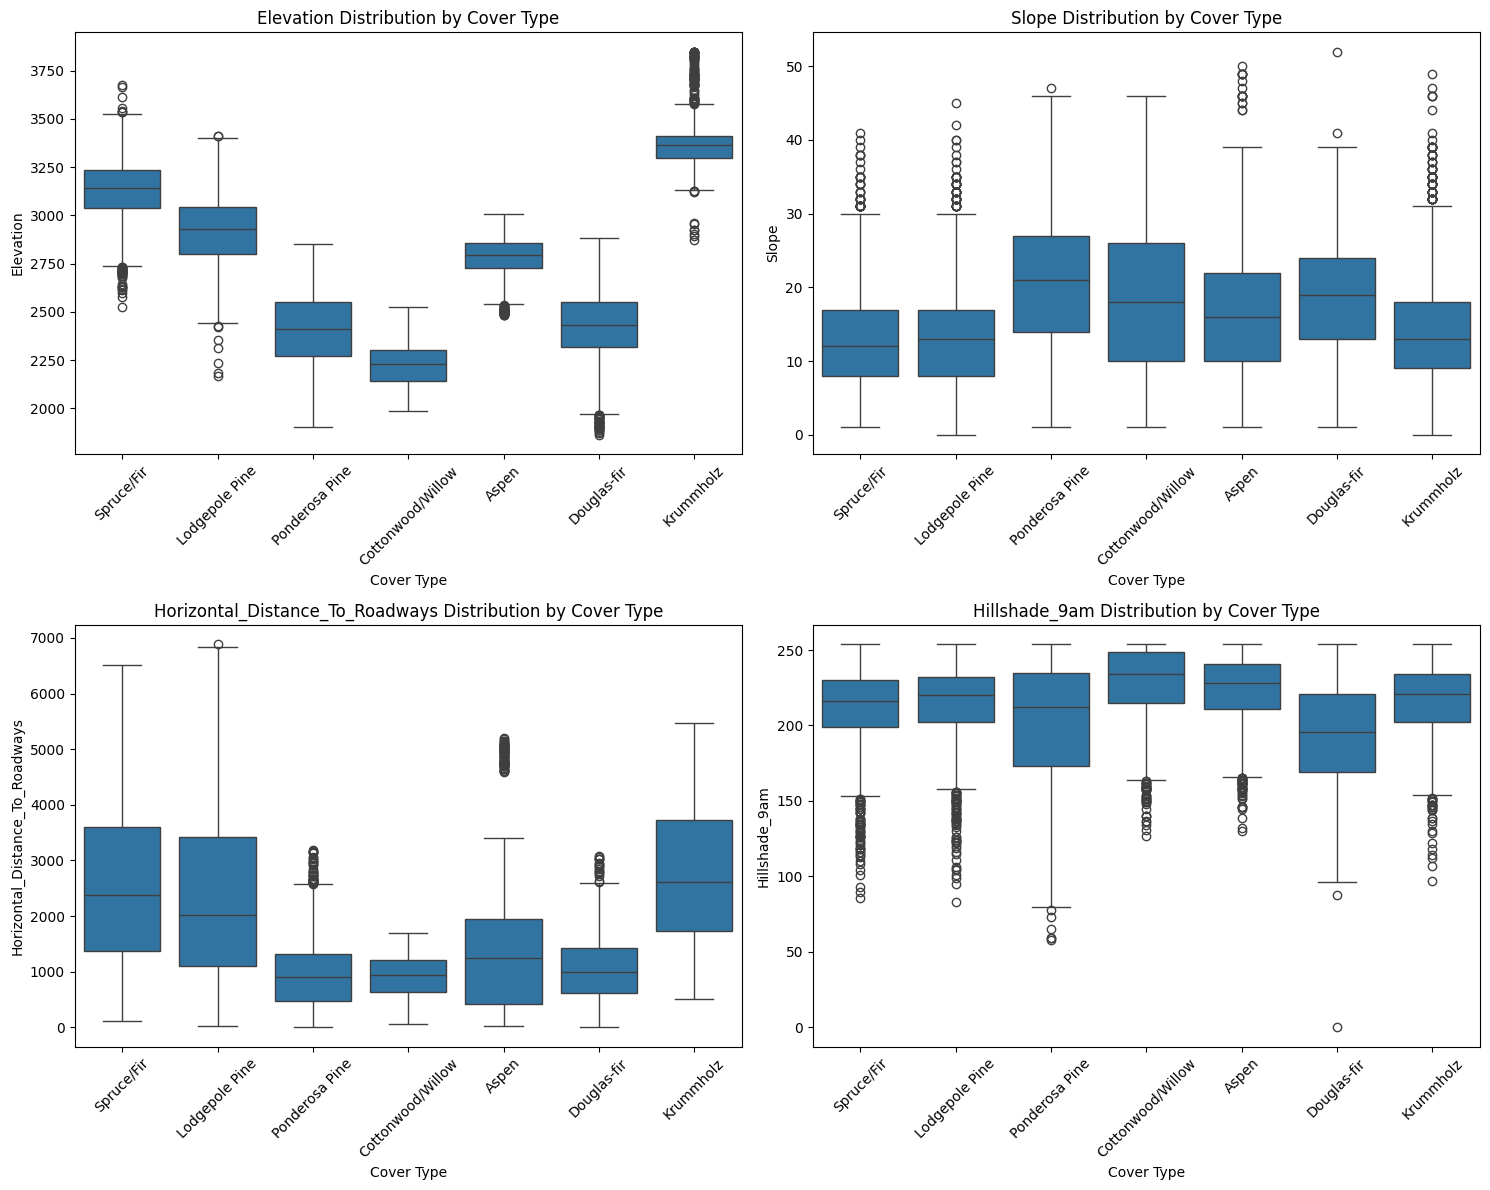

In [46]:
# Distribution of key features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
key_features = ['Elevation', 'Slope', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am']

for i, feature in enumerate(key_features):
    row, col = i // 2, i % 2
    sns.boxplot(x='Cover_Type', y=feature, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} Distribution by Cover Type')
    axes[row, col].set_xticklabels([cover_type_names[i] for i in range(1, 8)], rotation=45)
    axes[row, col].set_xlabel('Cover Type')
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [47]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 12096 samples
Test set: 3024 samples


In [48]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

In [49]:
# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

print("\nTraining Random Forest model...")
model.fit(X_train_scaled, y_train)



Training Random Forest model...


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [50]:
# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")



Cross-validation accuracy: 0.863 (±0.004)


In [51]:
# Evaluate on test set
y_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy: {test_accuracy:.3f}")



Test Accuracy: 0.860


In [52]:

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[cover_type_names[i] for i in range(1, 8)]))


Classification Report:
                   precision    recall  f1-score   support

       Spruce/Fir       0.78      0.78      0.78       432
   Lodgepole Pine       0.80      0.66      0.72       432
   Ponderosa Pine       0.83      0.81      0.82       432
Cottonwood/Willow       0.94      0.98      0.96       432
            Aspen       0.89      0.95      0.92       432
      Douglas-fir       0.83      0.87      0.85       432
        Krummholz       0.93      0.97      0.95       432

         accuracy                           0.86      3024
        macro avg       0.86      0.86      0.86      3024
     weighted avg       0.86      0.86      0.86      3024



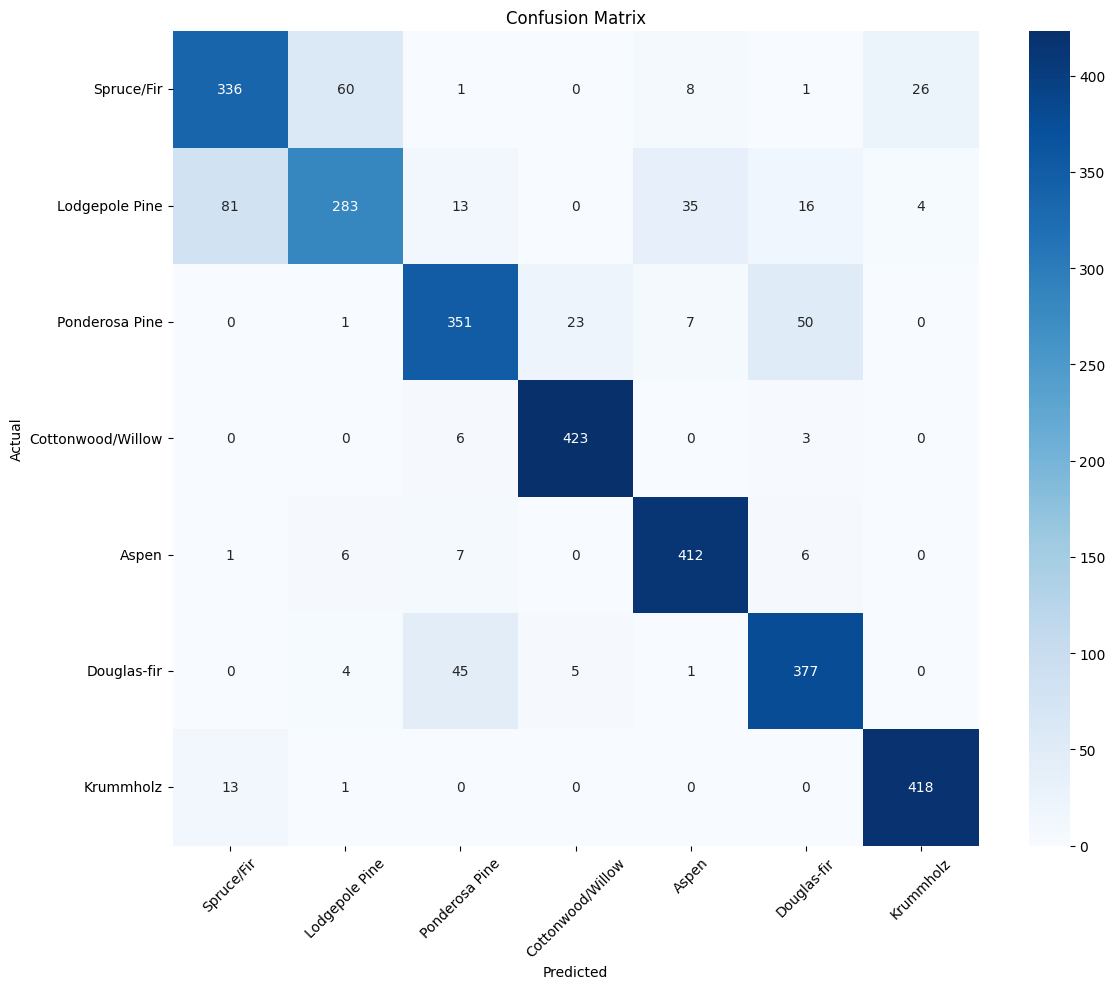

In [53]:
# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=[cover_type_names[i] for i in range(1, 8)],
           yticklabels=[cover_type_names[i] for i in range(1, 8)])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

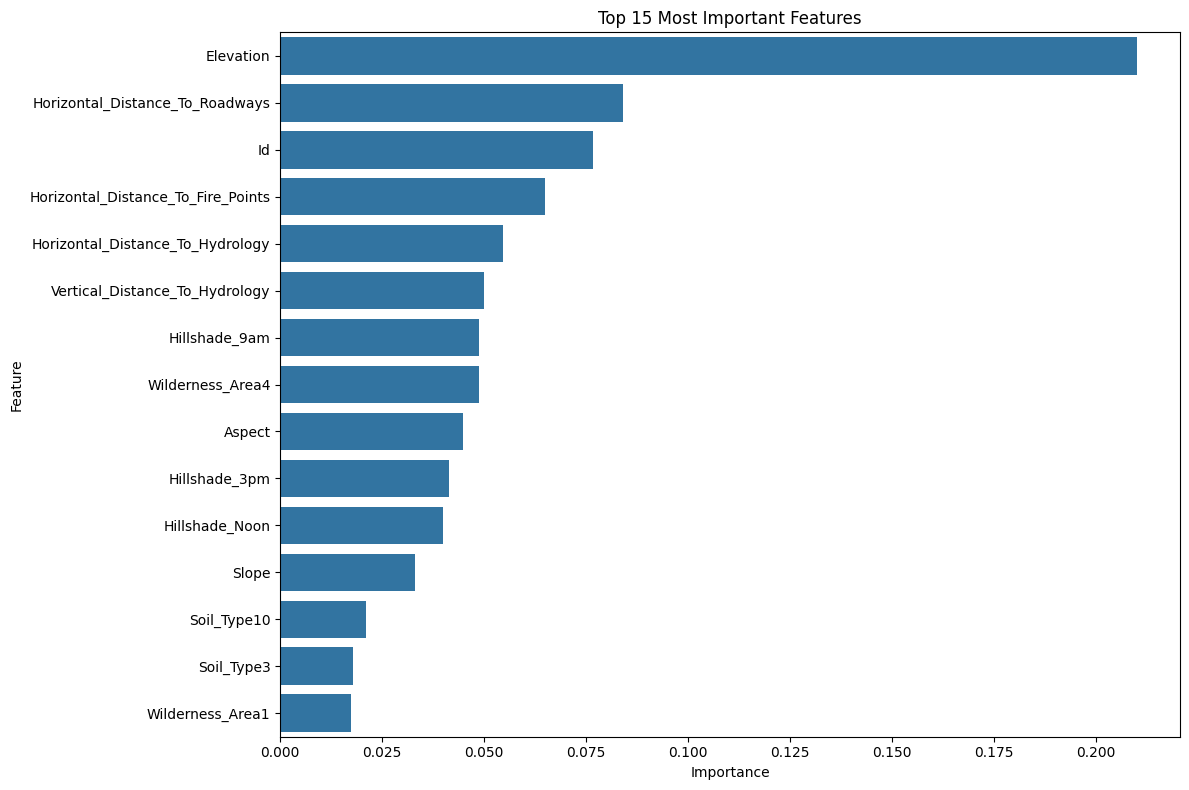

In [54]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [55]:
print("\nTop 10 most important features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"{i+1}. {row['feature']}: {row['importance']:.4f}")



Top 10 most important features:
2. Elevation: 0.2101
7. Horizontal_Distance_To_Roadways: 0.0841
1. Id: 0.0767
11. Horizontal_Distance_To_Fire_Points: 0.0649
5. Horizontal_Distance_To_Hydrology: 0.0547
6. Vertical_Distance_To_Hydrology: 0.0500
8. Hillshade_9am: 0.0487
15. Wilderness_Area4: 0.0486
3. Aspect: 0.0447
10. Hillshade_3pm: 0.0413


In [56]:
# Save model
joblib.dump(model, 'forest_cover_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModel and scaler saved successfully")



Model and scaler saved successfully


In [57]:
# Prediction function
def predict_forest_cover(input_features):
    input_df = pd.DataFrame([input_features])
    
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    input_df = input_df[X.columns]
    
    input_scaled = input_df.copy()
    input_scaled[numeric_features] = scaler.transform(input_df[numeric_features])
    
    prediction = model.predict(input_scaled)[0]
    probabilities = model.predict_proba(input_scaled)[0]
    return {
        'cover_type': cover_type_names[prediction],
        'cover_type_code': prediction,
        'confidence': probabilities[prediction - 1],
        'probabilities': {cover_type_names[i+1]: prob for i, prob in enumerate(probabilities)}
    }

In [58]:
# Example prediction
sample_patch = {
    'Elevation': 2850,
    'Aspect': 135,
    'Slope': 20,
    'Horizontal_Distance_To_Hydrology': 300,
    'Vertical_Distance_To_Hydrology': 40,
    'Horizontal_Distance_To_Roadways': 2000,
    'Hillshade_9am': 190,
    'Hillshade_Noon': 220,
    'Hillshade_3pm': 140,
    'Horizontal_Distance_To_Fire_Points': 1800,
    'Wilderness_Area1': 1,
    'Soil_Type_10': 1
}
for col in wilderness_cols + soil_cols:
    if col not in sample_patch:
        sample_patch[col] = 0

prediction = predict_forest_cover(sample_patch)

print(f"\nExample Prediction:")
print(f"Predicted Cover Type: {prediction['cover_type']}")
print(f"Confidence: {prediction['confidence']:.1%}")

print("\nProbability distribution:")
for cover_type, prob in prediction['probabilities'].items():
    print(f"  {cover_type}: {prob:.1%}")




Example Prediction:
Predicted Cover Type: Lodgepole Pine
Confidence: 67.0%

Probability distribution:
  Spruce/Fir: 20.0%
  Lodgepole Pine: 67.0%
  Ponderosa Pine: 0.0%
  Cottonwood/Willow: 0.0%
  Aspen: 12.0%
  Douglas-fir: 0.0%
  Krummholz: 1.0%
